In [2]:
import numpy as np
import matplotlib.pyplot as plt
import kidcalc as kc # KID model
import SC # properties of superconducting materials

# Alternative coordinate system
This notebook shows different cases for the Smith coordinate system:
    - case 1: a lorentzian vs. asymmetric dip
    - case 2: off-resonance measurement for a lorentzian
    - case 3: off-resonance measurement for a asymmetric dip
    - case 4: dealing with a rotated KID circle using two approaches:
        - the formulism of Zobrist et al. [2]
        - the Smith chart formulism with the circle rotation from Khalil et al. [1]

## user settings:
- KID parameters:
    - f0: KID resonance frequency (Hz)
    - Qc: coupling quality factor
    - V: Inductor volume (µm^3)
    - kbT0: (µeV)
    - ak: kinetic inductance fraction
    - etapb: pair breaking efficiency
    - xa: measure of the KID dip assymetry
- lmbda: Max. wavelength (energy) for the response curve (nm)

## required packages
- numpy
- matplotlib.pyplot
- kidcalc (S.A.H. de rooij)
- SC (S.A.H. de rooij)

## Relevant literature
[1] M. S. Khalil, M. J. A. Stoutimore, F. C. Wellstood, and K. D. Osborn, “An analysis method for asymmetric resonator transmission applied to superconducting devices,” Journal of Applied Physics, vol. 111, no. 5, p. 054510, Mar. 2012, doi: 10.1063/1.3692073.

[2] N. Zobrist et al., “Improving the dynamic range of single photon counting kinetic inductance detectors,” JATIS, vol. 7, no. 1, p. 010501, Feb. 2021, doi: 10.1117/1.JATIS.7.1.010501.


## Credit:
S.A.H. de Rooij & K. Kouwenhoven (Feb 2023)

In [3]:
kbT0 = 86.17 * .1 #µeV, operating temperature of 100 mK
f0 = 8.15e9 #Hz resonance frequency
hw0 = 6.528e-4*2*np.pi*f0*1e-6 #Effective readout power?, with reduced planck constant in µeV, µs 
Qi_sat = 1e16

Qc = 1.80e4     #Coupling quality factor
V = 15 # µm^3 inductor volume
supercond = SC.bTa() # material constants
ak = .96 # Kinetic Inductance fraction
beta = 2    #Thin film beta approximation

lmbda = 402 #nm, gives the max. E for the responsivity curve
etapb = .55 #Pair breaking efficiency 

# Measured value for beta-Ta KIDs
xa = -6.9097382e-6

In [4]:
# calculate excess quasiparticles due to photon, equilibrium quasiparticles and effective temperature
dNqp = etapb * 6.528e-4*2*np.pi* 3e8 / (lmbda * 1e-3) / supercond.D0
Nqp0 = V * kc.nqp(kbT0, supercond.D0, supercond)
kbTeff = kc.kbTeff((Nqp0 + dNqp)/V, supercond)

# calculate equilibrium complex conductivity, Qi, Lk and from that C and Lg (for later fres calc)
s10, s20 = kc.cinduct(hw0, supercond.D0, kbT0)
Qi_Nqp0 = 2/(ak*beta) * s20/s10
Qi0 = Qi_Nqp0 * Qi_sat / (Qi_Nqp0 + Qi_sat)  #Setting some sort of saturation limit on Q?
Lk0 = np.imag(1/(s10-1j*s20))/(2*np.pi*f0)

C = ak/(f0**2*Lk0)  #Capacitance from resonance freq definition, factor (2pi)^2 missing?

Lg = Lk0*(1/ak-1)

#calculate complex conductivities and excess quasiparticles during pulse (between kbT0 and kbTeff)
kbTarr = np.logspace(np.log10(kbT0), np.log10(kbTeff), 1000)
s1, s2, exNqp = np.zeros((3, len(kbTarr)))
for i, kbT in enumerate(kbTarr):
    s1[i], s2[i] = kc.cinduct(hw0, supercond.D0, kbT)
    exNqp[i] = V * kc.nqp(kbT, supercond.D0, supercond)

In [5]:
# Excess energy based on number of excess quaisparticles
exlambda = etapb * 6.528e-4*2*np.pi* 3e8 / (exNqp) / supercond.D0 * 1e3
exE = (6.528e-16*2*np.pi)*(3e8/(exlambda*1e-9))

In [6]:
# Make a S21 frequency sweep of twice the resonator linewidth
Q = Qc * Qi0 / (Qc + Qi0)
df_sweep = np.linspace(-10*f0/Q, 10*f0/Q, 1000)
f_sweep = np.linspace(f0-5e6, f0+5e6, 1000)

S21 = kc.S21_xa(Qi0, Qc, f0, df_sweep, f0, xa)
S21_lorA = kc.S21(Qi0, Qc, f_sweep, f0)
S21_lorB = kc.S21(Qi0, Qc, f_sweep, f0+1e6)
S21_lor = S21_lorA*S21_lorB

S21min = Q/Qi0 # S21 at resonance
xc = (1 + S21min)/2 # middle of the circle

print(S21min)
# Calculate Qi and f0 during pulse
Qi_Nqp = 2/(ak*beta) * s2/s1
Qiresp = Qi_Nqp * Qi_sat / (Qi_Nqp + Qi_sat)

Lk = np.imag(1/(s1-1j*s2))/(2*np.pi*f0)

fresp = 1/np.sqrt(C*(Lk + Lg))

0.00022314088154322382


# case 01: a lorentzian and asymmetric dip

## Plot two dips: a lorentzian and asymmetric dip with the same f0 and Q
The resonance frequency of the asymetric dip is not at the min. of the dip, but either to the left or right depending on the sign of the assymetry xa

C:\Users\hesel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\hesel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


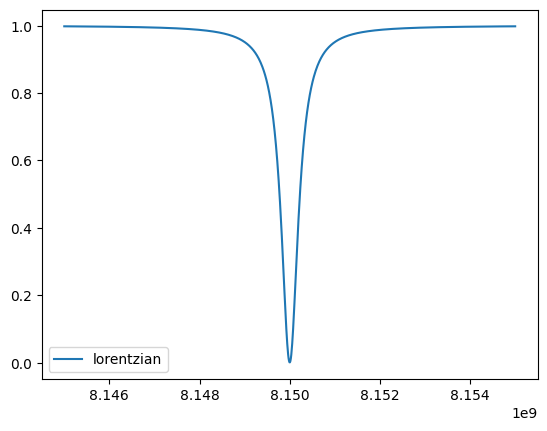

In [7]:
# fig = plt.subplots(figsize=(12, 8))

# plt.plot(df_sweep, np.abs(S21)**2, label = 'asymmetric')
plt.plot(f_sweep, S21_lorA, label = 'lorentzian')
plt.legend()
plt.ticklabel_format(useOffset=False)


# plt.plot(df_sweep, S21)

In [8]:
# calculate response for both sets of S21 based on a changing Qi and f0 -> change in complex cond.
S21resp = kc.S21_xa(Qiresp, Qc, f0, 0, fresp, xa)
S21resp_lor = kc.S21(Qiresp.reshape(-1,1), Qc, f_sweep, fresp.reshape(-1,1))

## Circles are translated such that the lorentzian circle has a centre at (0,0) and a radius of 1
the transformation is performed on both circles, it's clear that the asymmetric circle is not only rotated, but magnified as well

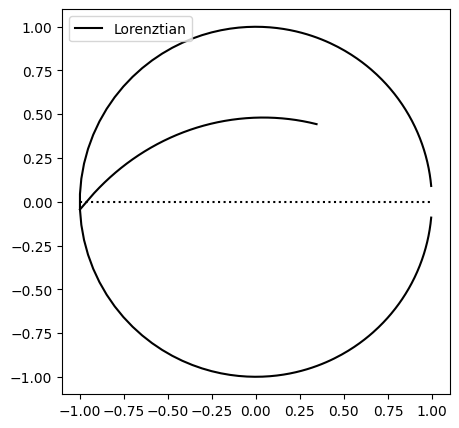

In [9]:
# plot circles for both including the response to the same energy event
plt.figure(figsize=(5, 5))
# plt.plot((S21.real-xc)/xc, S21.imag/xc, color = 'b', label = 'Asymmetric')
plt.plot((S21_lorA.real-xc)/xc, S21_lorA.imag/xc, color = 'k', label = 'Lorenztian')

# plt.plot((S21resp.real-xc)/xc, S21resp.imag/xc, color = 'b')
f_indx = np.argmin(S21_lorA)
plt.plot((S21resp_lor[:,f_indx].real-xc)/xc, S21resp_lor[:,f_indx].imag/xc, color = 'k')
plt.plot([-1,1],[0,0], 'k:')
plt.legend()

## Translate complex S21 data (I,Q) to response in both coordinate systems
for both the lorentzian and asymmetric case

In [10]:
# Translate to amplitude and phase
dA = 1 - np.sqrt((S21resp.real - xc) ** 2 + S21resp.imag ** 2) / (1 - xc)
theta = np.arctan2(S21resp.imag, (xc - S21resp.real))

# Translate to smith chart coordinates
Gamma = (S21resp.real-xc)/xc + 1j*S21resp.imag/xc
z = (1+Gamma)/(1-Gamma)
Rsmith = np.real(z)
Xsmith = np.imag(z)

# Phase response lorentzian
dA_lor = 1 - np.sqrt((S21resp_lor[:,f_indx].real - xc) ** 2 + S21resp_lor[:,f_indx].imag ** 2) / (1 - xc)
theta_lor = np.arctan2(S21resp_lor[:,f_indx].imag, (xc - S21resp_lor[:,f_indx].real))

# Smith chart lorentzian
Gamma_lor = (S21resp_lor[:,f_indx].real-xc)/xc + 1j*S21resp_lor[:,f_indx].imag/xc
z_lor = (1+Gamma_lor)/(1-Gamma_lor)
Rsmith_lor = np.real(z_lor)
Xsmith_lor = np.imag(z_lor)

## plot response for both circles in both coordinates. The smith chart coordinates are linear in both cases.

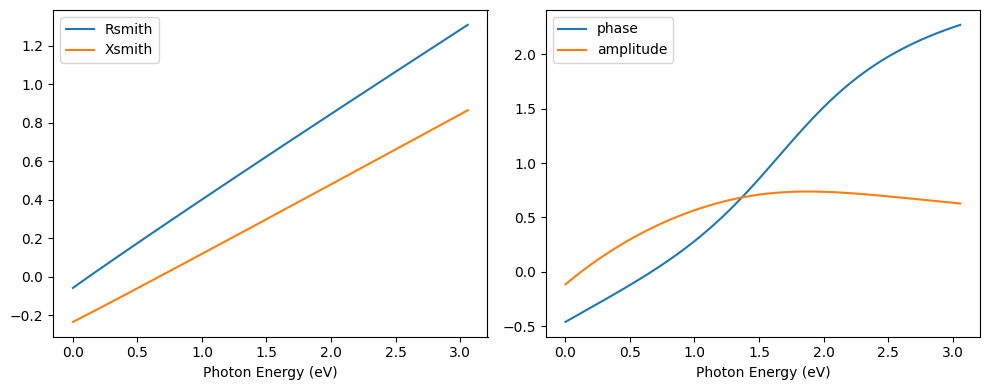

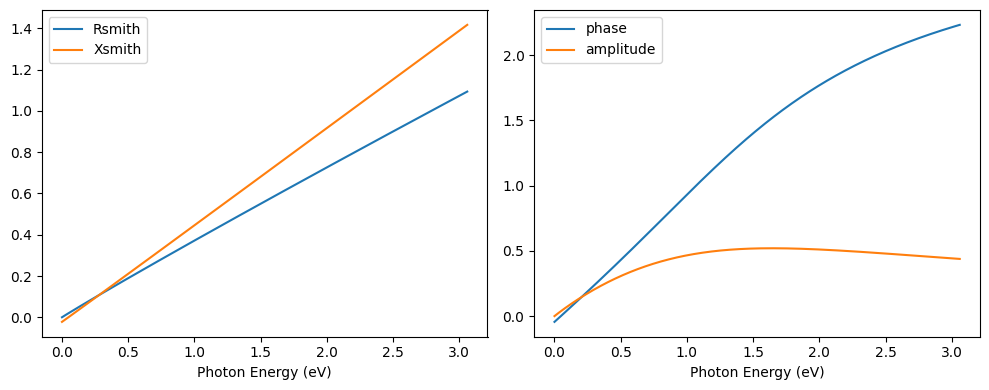

In [14]:
# plot smith against injected energy
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(exE, Rsmith, label = 'Rsmith')
axs[0].plot(exE, Xsmith, label = 'Xsmith')
axs[0].legend()

axs[1].plot(exE, theta, label = 'phase')
axs[1].plot(exE, dA, label = 'amplitude')
axs[1].legend()

for ax in axs:
    ax.set_xlabel('Photon Energy (eV)')
fig.tight_layout()


# plot smith against injected energy
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(exE, Rsmith_lor, label = 'Rsmith')
axs[0].plot(exE, Xsmith_lor, label = 'Xsmith')
axs[0].legend()

axs[1].plot(exE, theta_lor, label = 'phase')
axs[1].plot(exE, dA_lor, label = 'amplitude')
axs[1].legend()

for ax in axs:
    ax.set_xlabel('Photon Energy (eV)')
fig.tight_layout()

# Case 02: off-resonance measurement for a lorentzian

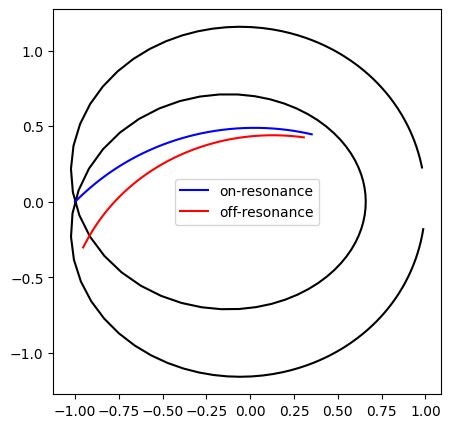

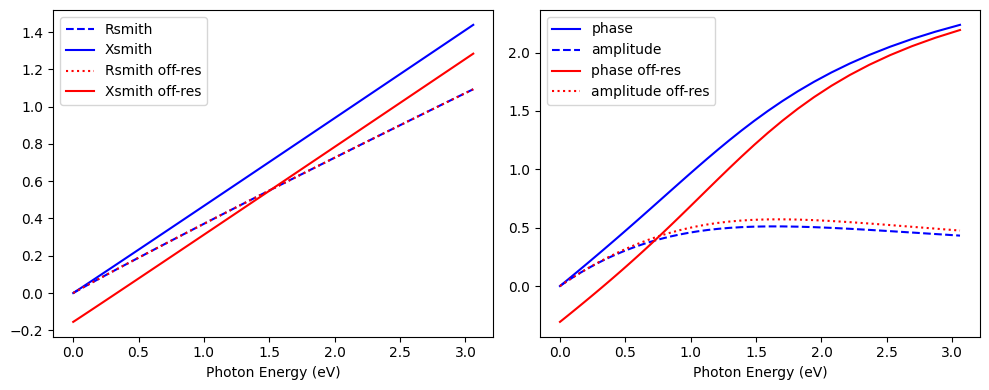

In [17]:
S21resp_off_res = kc.S21(Qiresp, Qc, f0, -35000, fresp)

plt.figure(figsize=(5, 5))
plt.plot((S21_lor.real-xc)/xc, S21_lor.imag/xc, color = 'k')
plt.plot((S21resp_lor.real-xc)/xc, S21resp_lor.imag/xc, color = 'b', label = 'on-resonance')
plt.plot((S21resp_off_res.real-xc)/xc, S21resp_off_res.imag/xc, color = 'r', label = 'off-resonance')
plt.legend()

# Phase response off resonance
dA_off_res = 1 - np.sqrt((S21resp_off_res.real - xc) ** 2 + S21resp_off_res.imag ** 2) / (1 - xc)
theta_off_res = np.arctan2(S21resp_off_res.imag, (xc - S21resp_off_res.real))

# Smith chart lorentzian
Gamma_off_res = (S21resp_off_res.real-xc)/xc + 1j*S21resp_off_res.imag/xc
z_off_res = (1+Gamma_off_res)/(1-Gamma_off_res)
Rsmith_off_res = np.real(z_off_res)
Xsmith_off_res = np.imag(z_off_res)

# plot smith against injected energy
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(exE, Rsmith_lor, 'b--', label = 'Rsmith')
axs[0].plot(exE, Xsmith_lor, 'b', label = 'Xsmith')
axs[0].plot(exE, Rsmith_off_res, 'r:', label = 'Rsmith off-res')
axs[0].plot(exE, Xsmith_off_res, 'r', label = 'Xsmith off-res')
axs[0].legend()

axs[1].plot(exE, theta_lor, 'b', label = 'phase')
axs[1].plot(exE, dA_lor, 'b--',label = 'amplitude')
axs[1].plot(exE, theta_off_res, 'r', label = 'phase off-res')
axs[1].plot(exE, dA_off_res, 'r:', label = 'amplitude off-res')
axs[1].legend()

for ax in axs:
    ax.set_xlabel('Photon Energy (eV)')
fig.tight_layout()

# Case 03: off-resonance for a asymetric dip
this is what typically happens when a lorentzian fit is used to find the resonance frequency of a KID
Note that the phase response of any case can be retreived from the linear smith chart coordinates

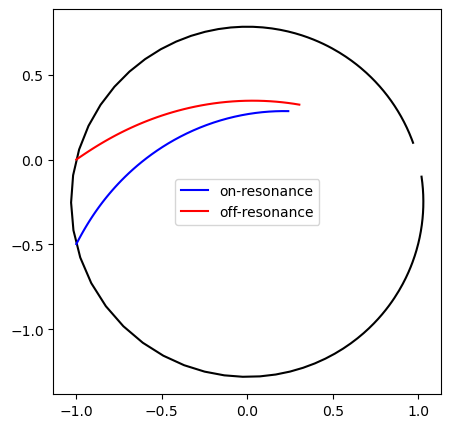

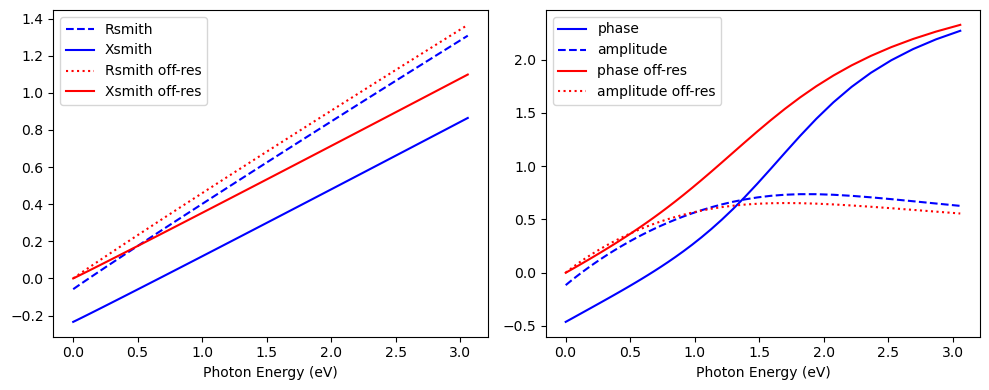

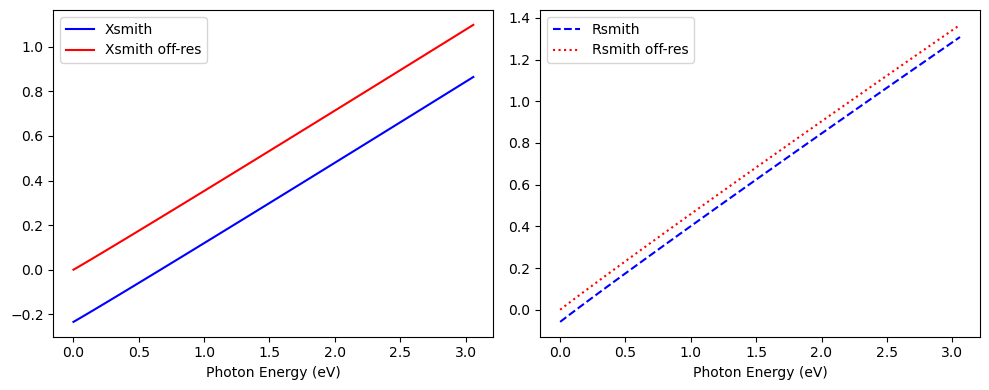

In [12]:
S21resp_off_res = kc.S21_xa(Qiresp, Qc, f0, 56300, fresp, xa)

plt.figure(figsize=(5, 5))
plt.plot((S21.real-xc)/xc, S21.imag/xc, color = 'k')
plt.plot((S21resp.real-xc)/xc, S21resp.imag/xc, color = 'b', label = 'on-resonance')
plt.plot((S21resp_off_res.real-xc)/xc, S21resp_off_res.imag/xc, color = 'r', label = 'off-resonance')
plt.legend()

# Phase response off resonance
dA_off_res = 1 - np.sqrt((S21resp_off_res.real - xc) ** 2 + S21resp_off_res.imag ** 2) / (1 - xc)
theta_off_res = np.arctan2(S21resp_off_res.imag, (xc - S21resp_off_res.real))

# Smith chart lorentzian
Gamma_off_res = (S21resp_off_res.real-xc)/xc + 1j*S21resp_off_res.imag/xc
z_off_res = (1+Gamma_off_res)/(1-Gamma_off_res)
Rsmith_off_res = np.real(z_off_res)
Xsmith_off_res = np.imag(z_off_res)

# plot smith against injected energy
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(exE, Rsmith, 'b--', label = 'Rsmith')
axs[0].plot(exE, Xsmith, 'b', label = 'Xsmith')
axs[0].plot(exE, Rsmith_off_res, 'r:', label = 'Rsmith off-res')
axs[0].plot(exE, Xsmith_off_res, 'r', label = 'Xsmith off-res')
axs[0].legend()

axs[1].plot(exE, theta, 'b', label = 'phase')
axs[1].plot(exE, dA, 'b--',label = 'amplitude')
axs[1].plot(exE, theta_off_res, 'r', label = 'phase off-res')
axs[1].plot(exE, dA_off_res, 'r:', label = 'amplitude off-res')
axs[1].legend()

for ax in axs:
    ax.set_xlabel('Photon Energy (eV)')
fig.tight_layout()

# plot smith against injected energy
fig, axs = plt.subplots(1, 2, figsize=(10, 4))


axs[0].plot(exE, Xsmith, 'b', label = 'Xsmith')
axs[0].plot(exE, Xsmith_off_res, 'r', label = 'Xsmith off-res')
axs[0].legend()

axs[1].plot(exE, Rsmith, 'b--', label = 'Rsmith')
axs[1].plot(exE, Rsmith_off_res, 'r:', label = 'Rsmith off-res')
axs[1].legend()

for ax in axs:
    ax.set_xlabel('Photon Energy (eV)')
fig.tight_layout()

# Case 04: rotating the asymmetric dip
there is two ways to do this:
 - The zobrist formalism
 - The Khalil approach

### Formulism from Zobrist et al.

In [13]:
x=0
pre_factor = (4*Q)/(1+4*Q**2*x**2)

Theta_2 = pre_factor*((S21resp.imag + 2*Qc*xa*(S21resp.real-1))/(2*Qc*np.abs(1-S21resp)**2))
D_2 = (1/2)*pre_factor*((S21resp.real - np.abs(S21resp)**2 + 2*Qc*xa*(S21resp.imag))/(Qc*np.abs(1-S21resp)**2) - Qi0**-1)

### Khalil approach (circle rotation and scaling)

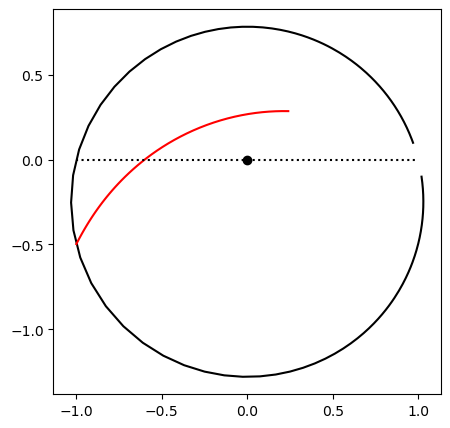

In [14]:
## This is the rotated circle
plt.figure(figsize=(5, 5))
plt.plot((S21.real-xc)/xc, S21.imag/xc, color = 'k')
plt.plot((S21resp.real-xc)/xc, S21resp.imag/xc, color = 'r')
plt.plot()
plt.plot([0], [0], 'ko')
plt.plot([-1, 1],[0, 0], ':k')

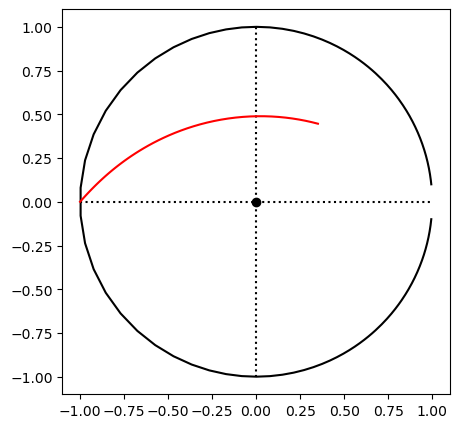

In [15]:
# rotate the circle with phi and scale the circle with cos(phi)
phi = np.arctan(2*Q*xa*((Qc+Qi0)/Qi0))

S21_shift = (S21.real-xc)/xc - 1 + 1j*S21.imag/xc

S21resp_shift = (S21resp.real-xc)/xc - 1 + 1j*S21resp.imag/xc

args = np.angle(S21_shift)
mags = np.abs(S21_shift)

args_resp = np.angle(S21resp_shift)
mags_resp = np.abs(S21resp_shift)

S21_rot = (mags*np.cos(phi))*np.exp(1j*(args + phi))
S21resp_rot = (mags_resp*np.cos(phi))*np.exp(1j*(args_resp + phi))

plt.figure(figsize=(5, 5))
plt.plot(S21_rot.real+1, S21_rot.imag, color = 'k')
plt.plot([-1, 1],[0, 0], ':k')
plt.plot([0, 0],[-1, 1], ':k')
plt.plot([0], [0], 'ko')

plt.plot(S21resp_rot.real+1, S21resp_rot.imag, color = 'r')

### Plot the response for both coordinate transformations
note that the response is identical up to a scale-factor. Zobrist et al. introduces a scale factor to match the smith chart reponse to the phase and amplitude response in the small signal limit.

Our approach, based on the Smith chart formulism and the Khalil rotation, uses the standard Smith chart coordinate scaling.

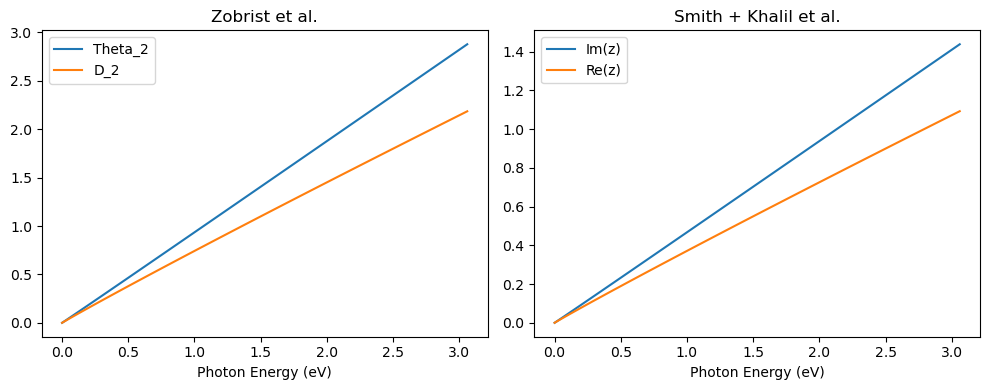

In [16]:
# Translate to smith chart coordinates
Gamma_rot = S21resp_rot.real+1 + 1j*S21resp_rot.imag

z_rot = (1+Gamma_rot)/(1-Gamma_rot)
Rsmith_rot = np.real(z_rot)
Xsmith_rot = np.imag(z_rot)


fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(exE, Theta_2, label = 'Theta_2')
axs[0].plot(exE, D_2, label = 'D_2')
axs[0].title.set_text('Zobrist et al.')
axs[0].legend()

axs[1].plot(exE, Xsmith_rot, label = 'Im(z)')
axs[1].plot(exE, Rsmith_rot, label = 'Re(z)')
axs[1].title.set_text('Smith + Khalil et al.')
axs[1].legend()

for ax in axs:
    ax.set_xlabel('Photon Energy (eV)')
fig.tight_layout()